In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('.')

from DNLutils import *
from scipy.signal import savgol_filter
from scipy.stats import chisquare

%matplotlib inline

First make a dummy image and a "real" ADC

In [2]:
seed = 123456
rng = np.random.default_rng(seed)
adcRange = 2**18
codes = np.arange(adcRange)
idealBinEdges = np.arange(adcRange+1)

muImage = 1e4
sigmaImage = np.sqrt(muImage)
n = int(1e6)
image = rng.normal(loc=muImage, scale=sigmaImage, size=n)

dnl = periodicDNL(codes)
trueAdcBins = buildADCBinsFromDNL(dnl)
trueDNL = calculateDNL(trueAdcBins)
trueINL = calculateINL(trueAdcBins)

Plot DNL, INL, and left edge offset of real ADC

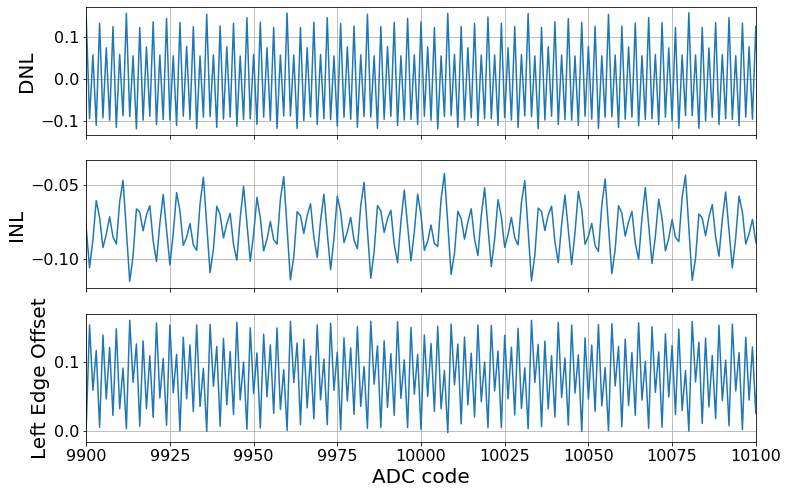

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axs[0].plot(trueDNL)
axs[0].tick_params(labelsize=16)
axs[0].set_ylabel("DNL", fontsize=20)
axs[0].grid(visible=True)

axs[1].plot(trueINL)
axs[1].tick_params(labelsize=16)
axs[2].set_xlabel("ADC code", fontsize=20)
axs[1].set_ylabel("INL", fontsize=20)
axs[1].grid(visible=True)

axs[2].plot(idealBinEdges, trueAdcBins - idealBinEdges)
axs[2].tick_params(labelsize=16)
axs[2].set_ylabel("Left Edge Offset", fontsize=20)
axs[2].set_xlim((9900, 10100))
axs[2].grid(visible=True)

plt.show(fig)

Digitize the dummy image with an ideal and the real ADC. Filter the ideal and real distributions.

In [4]:
idealDist, _ = np.histogram(image, bins=idealBinEdges)
adcDist, _ = np.histogram(image, bins=trueAdcBins)
minCounts = 150
mask = adcDist > minCounts
pdf = n / (sigmaImage * np.sqrt(2 * np.pi)) * np.exp(-(1/2) * 
                                                     ((codes - muImage)/
                                                      sigmaImage)**2)
filteredAdcDist = savgol_filter(adcDist, 65, 3)
filteredIdealDist = savgol_filter(idealDist, 65, 3)

Plot the real, ideal, and filtered real distributions and the PDF for the image

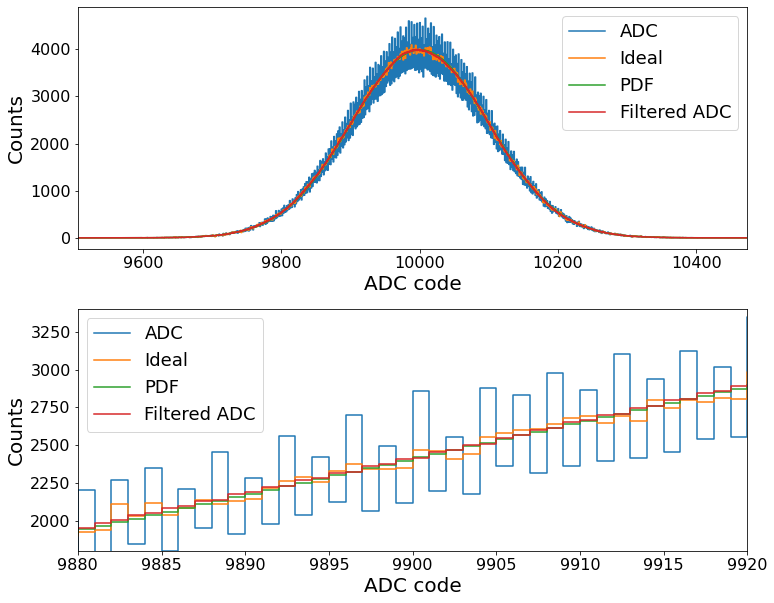

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

for ax in axs.ravel():
    ax.plot(codes, adcDist, label="ADC", ds="steps-post")
    ax.plot(codes, idealDist, label="Ideal", ds="steps-post")
    ax.plot(codes, pdf, label="PDF", ds="steps-post")
    ax.plot(codes, filteredAdcDist, label="Filtered ADC", ds="steps-post")

    ax.tick_params(labelsize=16)
    ax.set_xlabel("ADC code", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    ax.legend(fontsize=18)
    
axs[0].set_xlim((np.floor(image).min(), np.ceil(image).max()))
axs[1].set_xlim((9880, 9920))
axs[1].set_ylim((1800, 3400))

fig.subplots_adjust(hspace=0.25)
plt.show(fig)

Use the filtered ADC distribution, the ideal distribution, and the PDF as "expected distributions" to build three Model ADCs by placing the bins so the integral of the expected distributions integrates to give the real adc distribution.

In [6]:
adcBinsFromFiltered = buildADCBinsFromDist(adcDist, filteredAdcDist)
adcBinsFromIdeal = buildADCBinsFromDist(adcDist, idealDist)
adcBinsFromPDF = buildADCBinsFromDist(adcDist, pdf)

Calculate the differences of the constructed ADC and true ADC bin edges 

In [7]:
adcBinsFromFilterError =  trueAdcBins - adcBinsFromFiltered
adcBinsFromIdealError =  trueAdcBins - adcBinsFromIdeal
adcBinsFromPDFError =  trueAdcBins - adcBinsFromPDF

Plot these in a range where we have data

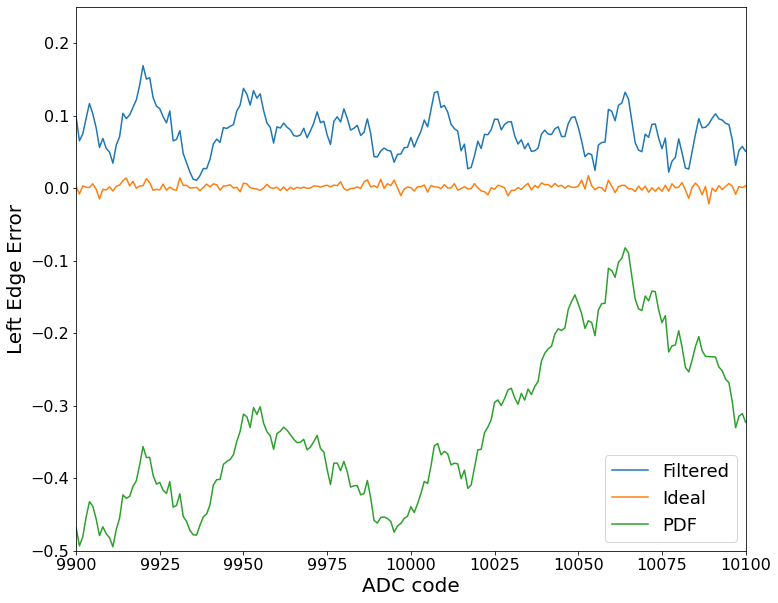

In [8]:
fig, ax = plt.subplots(figsize=(12, 10), sharex=True)

ax.plot(idealBinEdges, adcBinsFromFilterError, label="Filtered")
ax.plot(idealBinEdges, adcBinsFromIdealError, label="Ideal")
ax.plot(idealBinEdges, adcBinsFromPDFError, label="PDF")
ax.set_ylabel("Left Edge Error", fontsize=20)
ax.set_xlabel("ADC code", fontsize=20)
ax.set_xlim((9900, 10100))
ax.set_ylim((-0.5, 0.25))

ax.tick_params(labelsize=16)
ax.legend(fontsize=18, loc="lower right")

plt.show(fig)

Unsurprisingly, having the Ideal distribution in hand gives the most accurate model ADC. The Filtered distribution does pretty well though, better than the actual PDF. This makes sense to me - if the Ideal distribution has an excess of some code just due to sampling variance, the filtered curve will reflect that. Let's check the RMS errors in the edge offsets.

In [9]:
print("Bins derived using Filtered ADC Distribution RMS Error:"\
      f"{np.sqrt(np.mean(adcBinsFromFilterError[:-1][mask]**2)):.2e}")

print("Bins derived using Unfiltered Ideal Distribution RMS Error:"\
      f"{np.sqrt(np.mean(adcBinsFromIdealError[:-1][mask]**2)):.2e}")

print("Bins derived using PDF RMS Error:"\
      f"{np.sqrt(np.mean(adcBinsFromPDFError[:-1][mask]**2)):.2e}")


Bins derived using Filtered ADC Distribution RMS Error:9.22e-02
Bins derived using Unfiltered Ideal Distribution RMS Error:1.46e-02
Bins derived using PDF RMS Error:3.60e-01


Now let's check that applying the ADC Bins calculated using the filtered distribution back to the filtered distribution recovers the ADC distribution

In [10]:
distFromBinsFromFilter = applyADCtoDistributionSophisticated(adcBinsFromFiltered, filteredAdcDist)
distributionDiff = distFromBinsFromFilter - adcDist
normalizedDiff = distributionDiff / adcDist
rmsNormalizedDiff = np.sqrt(np.mean(normalizedDiff[mask]**2))
print(rmsNormalizedDiff)

5.266959993926035e-13


In [11]:
expectedAdcDist = applyADCtoDistributionSophisticated(adcBinsFromFiltered, pdf)
print(chisquare(adcDist[mask], f_exp=expectedAdcDist[mask]))
print(chisquare(idealDist[mask], f_exp=pdf[mask]))

Power_divergenceResult(statistic=44.89817166701724, pvalue=1.0)
Power_divergenceResult(statistic=467.8128148697345, pvalue=0.8930226464688761)


In [12]:
filterAdcError = pdf - filteredAdcDist
fractionalAdcError = filterAdcError / pdf
fractionalAdcPoissonStd = np.sqrt(filteredAdcDist) / pdf

filterIdealError = pdf - filteredIdealDist
fractionalIdealError = filterIdealError / pdf
fractionalIdealPoissonStd = np.sqrt(filteredIdealDist) / pdf

/home/adriansh/work/software/notebook/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/adriansh/work/software/notebook/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/home/adriansh/work/software/notebook/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/adriansh/work/software/notebook/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/adriansh/work/software/notebook/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/home/adriansh/work/software/noteboo

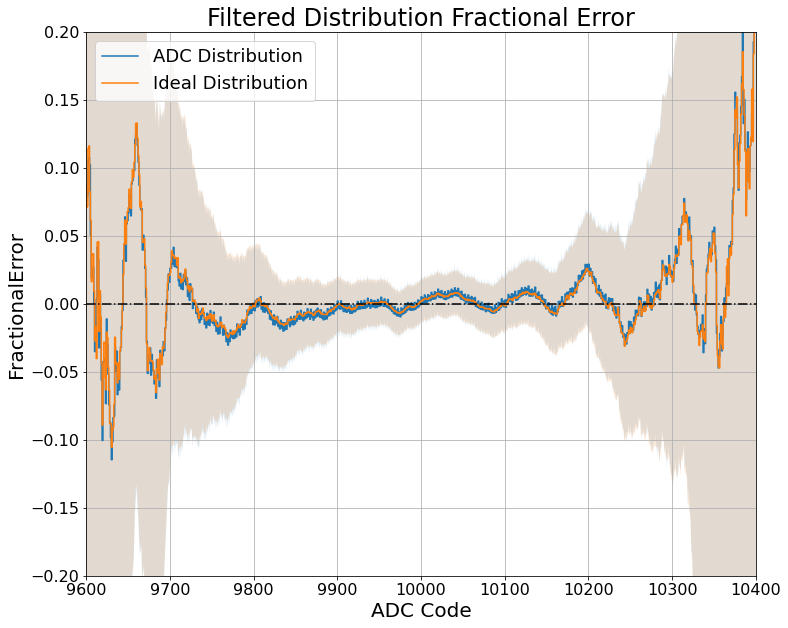

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(codes, fractionalAdcError, label="ADC Distribution", ds="steps-post")
ax.plot(codes, fractionalIdealError, label="Ideal Distribution", ds="steps-post")
ax.fill_between(codes, fractionalAdcError - fractionalAdcPoissonStd,
               fractionalAdcError + fractionalAdcPoissonStd, alpha=0.15)
ax.fill_between(codes, fractionalIdealError - fractionalIdealPoissonStd,
               fractionalIdealError + fractionalIdealPoissonStd, alpha=0.15)

ax.set_ylabel("FractionalError", fontsize=20)
ax.set_xlabel("ADC Code", fontsize=20)
ax.legend(fontsize=18)

ax.set_xlim((9600, 10400))
ax.set_ylim((-0.2, 0.2))
ax.tick_params(labelsize=16)
ax.axhline(ls="-.", c='k')
ax.set_title("Filtered Distribution Fractional Error", fontsize=24)
ax.grid(visible=True)

plt.show(fig)